In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from aux import get_seg
from disp import set_font_size, get_line
from time_stats import xcov_multi_with_confidence

cc = np.concatenate

SONG_FILE = 'data/simple/c_songs.npy'
COLORS = [(.7, .7, .7), 'b', 'r', (1, .5, 0)]

In [2]:
tmp = np.load(SONG_FILE, allow_pickle=True)[0]
songs = tmp['songs']
for song in songs:
    song[song == 3] = 2  # convert all p-fast to just pulse
dt = tmp['dt']
fps = tmp['fps']

In [3]:
durs = dt*np.array([len(s) for s in songs])
m_cpln = ~(durs == durs.max())

In [4]:
def plot_s(ax, t, s, extent, c, t_bar=1):
    """
    Note: extent: [x_min, x_max, y_min, y_max]
    """
    x_0 = extent[0]
    dx = (extent[1] - extent[0]) / len(s)
    modes = range(4)
    for mode in modes:
        bds = get_seg(s==mode, min_gap=1)[1]
        for istart, iend in bds:
            ax.fill_between([x_0+dx*istart, x_0+dx*iend], 2*[extent[2]], 2*[extent[3]], color=c[mode])
            
    dt = np.mean(np.gradient(t))
    dy_scale = .2*(extent[3]-extent[2])
    ax.fill_between([x_0, x_0+dx/dt*t_bar], 2*[extent[3] + 2*dy_scale], 2*[extent[3] + 3*dy_scale], color='k')
    return ax

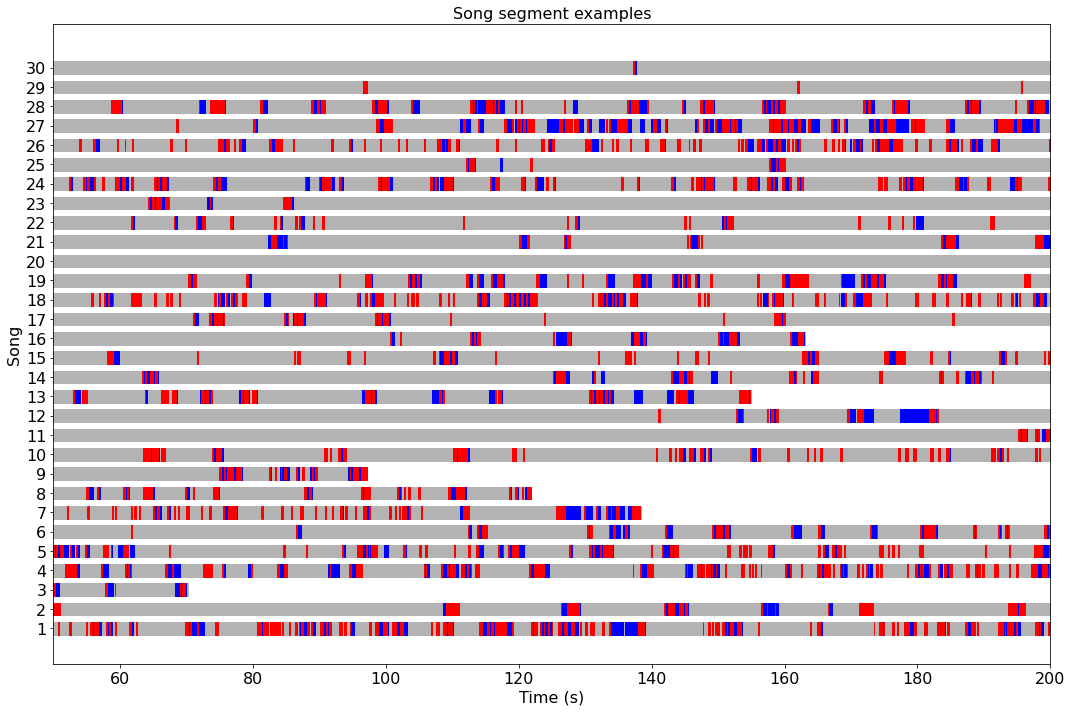

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), tight_layout=True)

y_ticks = []
for cs, isong in enumerate(range(30)):
    s = songs[isong]
    t = np.arange(len(s))*dt
    plot_s(ax, t, s, extent=[0, len(s)*dt, 1.5*cs, 1.5*cs+1], c=COLORS, t_bar=0)
    y_ticks.append(1.5*cs + .5)

ax.set_xlim(50, 200)
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.arange(len(y_ticks))+1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Song')
ax.set_title('Song segment examples')

set_font_size(ax, 16)

fig.savefig('supp/1_song_seg_xpls.png', dpi=200)

Time till copulation distribution

In [6]:
def plot_hists(x, bins=30, c='k', lw=3, fig=None, axs=None, **kwargs):
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), tight_layout=True)
    cts, bins = np.histogram(x, bins=bins, **kwargs)
    binc = .5*(bins[:-1] + bins[1:])
    axs[0].plot(binc, cts, c=c, lw=lw)
    axs[1].semilogy(binc, cts, c=c, lw=lw)
    axs[2].loglog(binc, cts, c=c, lw=lw)
    
    return fig, axs

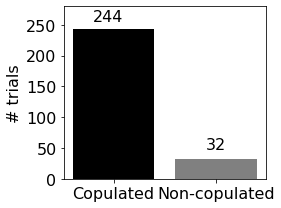

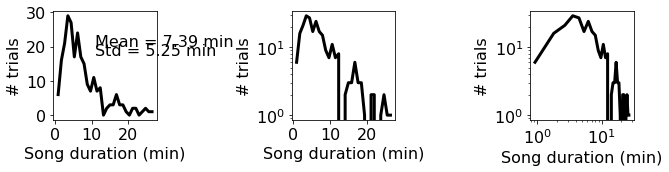

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
n = len(songs)
n_cpln = m_cpln.sum()

ax.bar([0, 1], [n_cpln, n-n_cpln], color=['k', 'gray'], align='center')
ax.set_ylim(0, 280)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Copulated', 'Non-copulated'])
ax.set_ylabel('# trials')
ax.text(-.2, 256, f'{n_cpln}', fontsize=16)
ax.text(.9, 48, f'{n-n_cpln}', fontsize=16)

set_font_size(ax, 16)

fig.savefig('supp/1_frac_cop.svg')

t_cpln = durs[durs < durs.max()]

fig, axs = plot_hists(t_cpln/60, bins=30)
for ax in axs:
    ax.set_xlabel('Song duration (min)')
    ax.set_ylabel('# trials')
    set_font_size(ax, 16)
axs[0].text(11, 20, f'Mean = {t_cpln.mean()/60:.2f} min', fontsize=16)
axs[0].text(11, 17.5, f'Std = {t_cpln.std()/60:.2f} min', fontsize=16)

fig.savefig('ms/fig_1_song_dur_distr.svg')

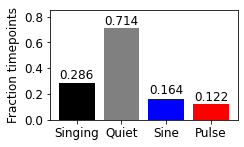

In [9]:
songs_cc = cc(songs)
frc_sng = np.mean(songs_cc > 0)
frc_qui = np.mean(songs_cc == 0)
frc_sin = np.mean(songs_cc == 1)
frc_psl = np.mean(songs_cc == 2)
# frc_pfs = np.mean(songs_cc == 3)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.1), tight_layout=True)
ax.bar(range(4), [frc_sng, frc_qui, frc_sin, frc_psl], color=['k', 'gray', 'b', 'r'], align='center')
ax.set_ylim(0, .85)
ax.set_xticks(range(4))
ax.set_xticklabels(['Singing', 'Quiet', 'Sine', 'Pulse'])
ax.set_ylabel('Fraction timepoints')
ax.text(0, .32, f'{frc_sng:.3f}', ha='center', fontsize=12)
ax.text(1, .74, f'{frc_qui:.3f}', ha='center', fontsize=12)
ax.text(2, .2, f'{frc_sin:.3f}', ha='center', fontsize=12)
ax.text(3, .15, f'{frc_psl:.3f}', ha='center', fontsize=12)
# ax.text(4, .08, f'{frc_pfs:.3f}', ha='center', fontsize=16)
set_font_size(ax, 12)

fig.savefig('supp/1_frac_song_mode_timepoints.svg')
fig.savefig('ms/fig_1_song_mode_hist.svg')

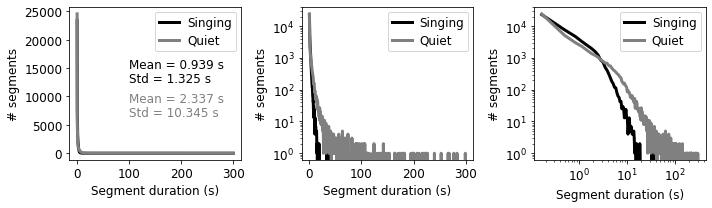

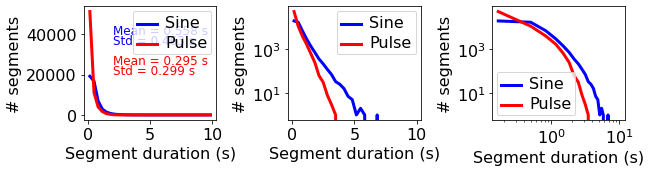

In [11]:
durs_sng = []
durs_qui = []
durs_sin = []
durs_psl = []

for s in songs:
    bds_sng = get_seg(s > 0, min_gap=1)[1]*dt
    durs_sng.extend(bds_sng[:, 1] - bds_sng[:, 0])
    
    bds_qui = get_seg(s == 0, min_gap=1)[1]*dt
    durs_qui.extend(bds_qui[:, 1] - bds_qui[:, 0])
    
    bds_sin = get_seg(s == 1, min_gap=1)[1]*dt
    durs_sin.extend(bds_sin[:, 1] - bds_sin[:, 0])
    
    bds_psl = get_seg(s == 2, min_gap=1)[1]*dt
    durs_psl.extend(bds_psl[:, 1] - bds_psl[:, 0])
    
durs_sng = np.array(durs_sng)
durs_qui = np.array(durs_qui)
durs_sin = np.array(durs_sin)
durs_psl = np.array(durs_psl)

fig, axs = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)
bins = np.linspace(0, 300, 901)
plot_hists(durs_sng, bins=bins, c='k', lw=3, fig=fig, axs=axs)
plot_hists(durs_qui, bins=bins, c='gray', lw=3, fig=fig, axs=axs)

for ax in axs:
    ax.set_xlabel('Segment duration (s)')
    ax.set_ylabel('# segments')
    ax.legend(['Singing', 'Quiet'])
set_font_size(axs, 12)

axs[0].text(100, 15000, f'Mean = {durs_sng.mean():.3f} s', color='k', fontsize=12)
axs[0].text(100, 12500, f'Std = {durs_sng.std():.3f} s', color='k', fontsize=12)
axs[0].text(100, 9000, f'Mean = {durs_qui.mean():.3f} s', color='gray', fontsize=12)
axs[0].text(100, 6500, f'Std = {durs_qui.std():.3f} s', color='gray', fontsize=12)

fig.savefig('supp/1_sing_quiet_dur_distrs.svg')

fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), tight_layout=True)
bins = np.linspace(0, 10, 31)
plot_hists(durs_sin, bins=bins, c='b', lw=3, fig=fig, axs=axs)
plot_hists(durs_psl, bins=bins, c='r', lw=3, fig=fig, axs=axs)

for ax in axs:
    ax.set_xlabel('Segment duration (s)')
    ax.set_ylabel('# segments')
    ax.legend(['Sine', 'Pulse'])
set_font_size(axs, 16)

axs[0].text(2, 40000, f'Mean = {durs_sin.mean():.3f} s', color='b', fontsize=12)
axs[0].text(2, 35000, f'Std = {durs_sin.std():.3f} s', color='b', fontsize=12)
axs[0].text(2, 25000, f'Mean = {durs_psl.mean():.3f} s', color='r', fontsize=12)
axs[0].text(2, 20000, f'Std = {durs_psl.std():.3f} s', color='r', fontsize=12)

fig.savefig('supp/1_mode_dur_distrs.svg')
fig.savefig('ms/fig_1_mode_seg_durs.svg')